\begin{array}{|c|c|c|}
\hline
\textbf{Category} & \textbf{No Regularization} & \textbf{With L2 Regularization} \\
\hline
\text{Loss (Cross Entropy)} &
-\dfrac{1}{n}\left[\sum_{i=1}^{n} y_i \log(h_i) + (1-y_i)\log(1-h_i)\right] &
-\dfrac{1}{n}\sum_{i=1}^{n} \left[y_i \log(h_i) + (1-y_i)\log(1-h_i)\right] + \dfrac{\lambda \lVert \theta \rVert^{2}}{n} \\
\hline
\text{Gradient} &
\dfrac{1}{n} X^{T}(h - y) &
\dfrac{1}{n} X^{T}(h - y) + \dfrac{2\lambda \theta}{n} \quad (\text{bias term set to } 0) \\
\hline
\text{Gradient update} &
\theta_{i+1} = \theta_i - \alpha \dfrac{X^{T}(h - y)}{n} &
\theta_{i+1} = \theta_i - \left[\alpha \dfrac{X^{T}(h - y)}{n} + \alpha \dfrac{2\lambda \theta}{n}\right] \\
\hline
\end{array}

### Non-Linear Transformation
**Think what is variable and what is constant in the equation!! => Feature Transformation / Representation into higher dimension**
<div>
    <img src="NonLinearTransformation.png" height="500" width="500" />
</div>

REGULARIZATION: BEFORE vs AFTER

Dataset: 140 train, 60 test samples

[1/2] Training WITHOUT regularization...
  Final Train Loss: 0.2210
  Final Test Loss:  0.3761
  Gap (Overfitting): 0.1550

[2/2] Training WITH L2 regularization (λ=0.005)...
  Final Train Loss: 0.2437
  Final Test Loss:  0.3754
  Gap (Overfitting): 0.1317

✓ Overfitting Gap Reduced by: 0.0234

VISUALIZATION SAVED!

KEY TAKEAWAYS:
• RED dashed line (BEFORE): Complex, wiggly boundary - OVERFITS
• GREEN solid line (AFTER): Smoother boundary - GENERALIZES better
• Smaller gap between train/test loss = LESS OVERFITTING


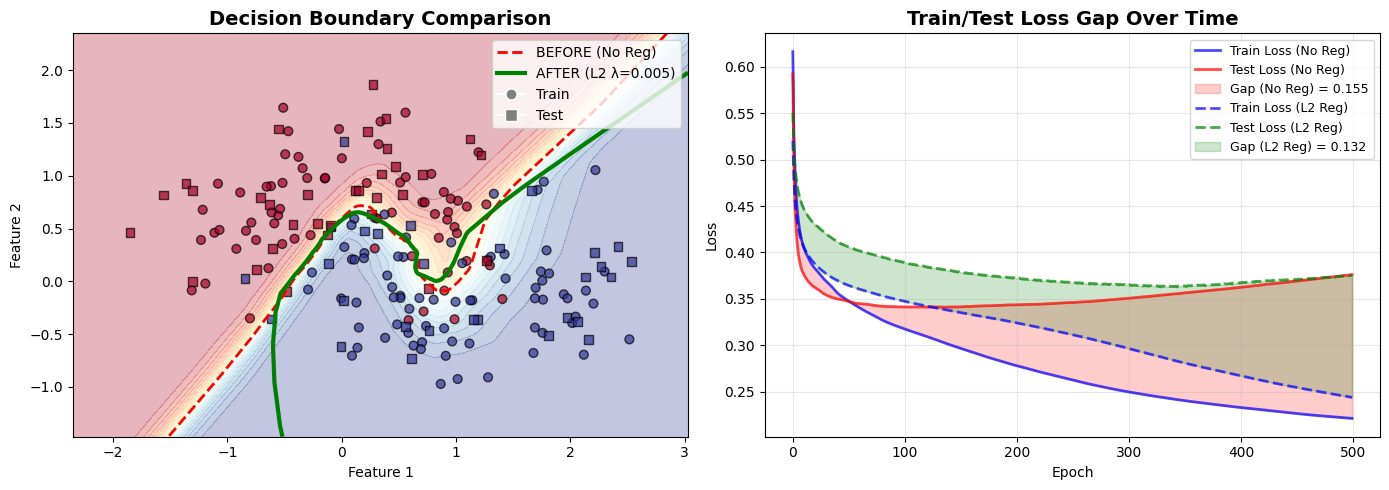

In [4]:
"""
SIMPLIFIED Regularization Demo - Before vs After
Shows: Decision Boundary + Train/Test Loss Gap
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

np.random.seed(42)


class SimpleNN:
    """Deeper neural network with optional L2 regularization for non-linear boundaries"""
    
    def __init__(self, l2_lambda=0.0):
        self.l2_lambda = l2_lambda
        # Initialize weights for 3-layer network (deeper = more non-linear)
        self.W1 = np.random.randn(2, 32) * 0.5
        self.b1 = np.zeros((1, 32))
        self.W2 = np.random.randn(32, 32) * 0.5
        self.b2 = np.zeros((1, 32))
        self.W3 = np.random.randn(32, 1) * 0.5
        self.b3 = np.zeros((1, 1))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, X):
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        
        # Layer 3 (output)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.sigmoid(self.z3)
        return self.a3
    
    def loss(self, y_true, y_pred):
        m = y_true.shape[0]
        # Cross-entropy
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        ce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # L2 regularization penalty
        if self.l2_lambda > 0:
            l2_penalty = (self.l2_lambda / (2 * m)) * (
                np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2)
            )
            return ce_loss + l2_penalty
        return ce_loss
    
    def train_step(self, X, y, lr=0.1):
        m = X.shape[0]
        
        # Forward
        y_pred = self.forward(X)
        
        # Backward - Layer 3
        dz3 = y_pred - y
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m
        
        # Backward - Layer 2
        dz2 = np.dot(dz3, self.W3.T) * (self.z2 > 0)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Backward - Layer 1
        dz1 = np.dot(dz2, self.W2.T) * (self.z1 > 0)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Add L2 gradient
        if self.l2_lambda > 0:
            dW3 += (self.l2_lambda / m) * self.W3
            dW2 += (self.l2_lambda / m) * self.W2
            dW1 += (self.l2_lambda / m) * self.W1
        
        # Update
        self.W3 -= lr * dW3
        self.b3 -= lr * db3
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
    
    def train(self, X_train, y_train, X_test, y_test, epochs=500):
        train_losses = []
        test_losses = []
        
        for epoch in range(epochs):
            self.train_step(X_train, y_train)
            
            # Track losses
            train_pred = self.forward(X_train)
            test_pred = self.forward(X_test)
            train_losses.append(self.loss(y_train, train_pred))
            test_losses.append(self.loss(y_test, test_pred))
        
        return train_losses, test_losses


# Generate data
print("=" * 60)
print("REGULARIZATION: BEFORE vs AFTER")
print("=" * 60)

X, y = make_moons(n_samples=200, noise=0.35, random_state=42)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nDataset: {len(X_train)} train, {len(X_test)} test samples")


# BEFORE: No Regularization
print("\n[1/2] Training WITHOUT regularization...")
model_before = SimpleNN(l2_lambda=0.0)
train_loss_before, test_loss_before = model_before.train(X_train, y_train, X_test, y_test, epochs=500)

print(f"  Final Train Loss: {train_loss_before[-1]:.4f}")
print(f"  Final Test Loss:  {test_loss_before[-1]:.4f}")
print(f"  Gap (Overfitting): {abs(train_loss_before[-1] - test_loss_before[-1]):.4f}")


# AFTER: With L2 Regularization
print("\n[2/2] Training WITH L2 regularization (λ=0.005)...")
model_after = SimpleNN(l2_lambda=0.005)
train_loss_after, test_loss_after = model_after.train(X_train, y_train, X_test, y_test, epochs=500)

print(f"  Final Train Loss: {train_loss_after[-1]:.4f}")
print(f"  Final Test Loss:  {test_loss_after[-1]:.4f}")
print(f"  Gap (Overfitting): {abs(train_loss_after[-1] - test_loss_after[-1]):.4f}")


# Calculate improvement
gap_improvement = abs(train_loss_before[-1] - test_loss_before[-1]) - abs(train_loss_after[-1] - test_loss_after[-1])
print(f"\n✓ Overfitting Gap Reduced by: {gap_improvement:.4f}")


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Decision Boundaries Comparison
ax1 = axes[0]

# Create mesh for decision boundary
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot BEFORE (left half)
Z_before = model_before.forward(np.c_[xx.ravel(), yy.ravel()])
Z_before = Z_before.reshape(xx.shape)
contour1 = ax1.contourf(xx, yy, Z_before, alpha=0.3, cmap='RdYlBu', levels=20)
ax1.contour(xx, yy, Z_before, levels=[0.5], colors='red', linewidths=2, linestyles='--')

# Plot AFTER (overlay with different style)
Z_after = model_after.forward(np.c_[xx.ravel(), yy.ravel()])
Z_after = Z_after.reshape(xx.shape)
ax1.contour(xx, yy, Z_after, levels=[0.5], colors='green', linewidths=3)

# Scatter points
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', 
           edgecolors='black', s=40, alpha=0.7, label='Train')
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', 
           edgecolors='black', s=40, marker='s', alpha=0.7, label='Test')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='BEFORE (No Reg)'),
    Line2D([0], [0], color='green', linewidth=3, label='AFTER (L2 λ=0.005)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Train'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Test')
]
ax1.legend(handles=legend_elements, loc='upper right')
ax1.set_title('Decision Boundary Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')


# RIGHT: Train/Test Loss Gap
ax2 = axes[1]

epochs = range(len(train_loss_before))

# BEFORE
ax2.plot(epochs, train_loss_before, 'b-', linewidth=2, label='Train Loss (No Reg)', alpha=0.7)
ax2.plot(epochs, test_loss_before, 'r-', linewidth=2, label='Test Loss (No Reg)', alpha=0.7)
ax2.fill_between(epochs, train_loss_before, test_loss_before, alpha=0.2, color='red', 
                 label=f'Gap (No Reg) = {abs(train_loss_before[-1] - test_loss_before[-1]):.3f}')

# AFTER
ax2.plot(epochs, train_loss_after, 'b--', linewidth=2, label='Train Loss (L2 Reg)', alpha=0.7)
ax2.plot(epochs, test_loss_after, 'g--', linewidth=2, label='Test Loss (L2 Reg)', alpha=0.7)
ax2.fill_between(epochs, train_loss_after, test_loss_after, alpha=0.2, color='green',
                 label=f'Gap (L2 Reg) = {abs(train_loss_after[-1] - test_loss_after[-1]):.3f}')

ax2.set_title('Train/Test Loss Gap Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

print("\n" + "=" * 60)
print("VISUALIZATION SAVED!")
print("=" * 60)
print("\nKEY TAKEAWAYS:")
print("• RED dashed line (BEFORE): Complex, wiggly boundary - OVERFITS")
print("• GREEN solid line (AFTER): Smoother boundary - GENERALIZES better")
print("• Smaller gap between train/test loss = LESS OVERFITTING")
print("=" * 60)